# Models 8/02

Sections: Read and clean dataset; Selected EDA; Train-test split; Removing seasonal trend; PCA and clustering; Preparing readout functions; Predictive models


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from pandas.tseries.holiday import USFederalHolidayCalendar

from scipy import optimize

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

## Read and clean dataset

In [3]:
data2019 = pd.read_csv('2019_RAW_APC_Data.csv.gz')

In [4]:
for col in ['route finish time','route start time','stop arrival time']:
    data2019[col] = pd.to_datetime(data2019[col])

In [5]:
df = data2019

df['Crowded'] = df['passwithin']>74
df['Supercrowded'] = df['passwithin']>134
df['Capacity'] = df['passwithin']>194
df['UnderNeg5'] = df['passwithin']<-5
df['NegAFew'] = df['passwithin'].between(-5,-1)
df['Over250'] = df['passwithin']>250
df['AllObservations'] = True

df['Crowded000'] = df['passwithin']>0
df['Crowded010'] = df['passwithin']>10
df['Crowded020'] = df['passwithin']>20
df['Crowded030'] = df['passwithin']>30
df['Crowded040'] = df['passwithin']>40
df['Crowded050'] = df['passwithin']>50
df['Crowded060'] = df['passwithin']>60
df['Crowded070'] = df['passwithin']>70
df['Crowded080'] = df['passwithin']>80
df['Crowded090'] = df['passwithin']>90
df['Crowded100'] = df['passwithin']>100
df['Crowded110'] = df['passwithin']>110
df['Crowded120'] = df['passwithin']>120
df['Crowded130'] = df['passwithin']>130
df['Crowded140'] = df['passwithin']>140
df['Crowded150'] = df['passwithin']>150
df['Crowded160'] = df['passwithin']>160
df['Crowded170'] = df['passwithin']>170
df['Crowded180'] = df['passwithin']>180
df['Crowded190'] = df['passwithin']>190
df['Crowded200'] = df['passwithin']>200
df['Crowded210'] = df['passwithin']>210
df['Crowded220'] = df['passwithin']>220
df['Crowded230'] = df['passwithin']>230
df['Crowded240'] = df['passwithin']>240

In [6]:
df = data2019

df['TOD'] = df['stop arrival time'].dt.time
df['DOW'] = df['stop arrival time'].dt.dayofweek # 0 is Monday, 6 is Sunday
df['DOW_name'] = df['stop arrival time'].dt.day_name()
df['Date'] = df['stop arrival time'].dt.date
df['Hour'] = df['stop arrival time'].dt.hour
df['Minute'] = df['stop arrival time'].dt.minute
df['Minute_od'] = df['Hour'] * 60 + df['Minute']
df['Month'] = df['stop arrival time'].dt.month
df['Month_name'] = df['stop arrival time'].dt.month_name()
df['Season'] = df['stop arrival time'].dt.quarter
df['DOY'] = df['stop arrival time'].dt.dayofyear
df['WOY'] = df['stop arrival time'].dt.isocalendar().week

In [7]:
df = data2019

# Create a station ID
# Use a dictionary
names = ['Zero','Angle','SeaTac','Tukwila','Rainier','Othello',
         'Columbia','Baker','Beacon','SODO','Stadium','Intl District',
         'Pioneer','University','Westlake','Capitol Hill ','UW ']

for idx, name in enumerate(names):
    df.loc[df['station name']==name, 'sta_ID'] = idx
    df.loc[df['next station']==name, 'nxsta_ID'] = idx
    
df['sta_ID'] = df['sta_ID'].astype('int32')
df['nxsta_ID'] = df['nxsta_ID'].astype('int32')
df['stadir_ID'] = df['sta_ID'] * 100 + df['nxsta_ID']

In [8]:
# df01 filters out routedones that have >20 stops
rtd = data2019.groupby('routedone').count()['railcar ID']
rtd.name = 'count'
overmuch = rtd[rtd>20]
df01 = data2019[~data2019['routedone'].isin(overmuch.index)]

In [9]:
# df02 is df01 but without >210 observations
df02 = df01[~df01['Crowded210']]

In [10]:
# df03 is df02 but without any against-equation trips

against_calc = pd.read_csv('routes_against_calc.csv').iloc[:,0]

df03 = df02[~df02['routedone'].isin(against_calc)]

In [11]:
# df04 is df03 but without any trips where the train visited stations out of sequence.
# In other words, df04 consists of only normal stadir values.

abnormal = pd.read_csv('abnormal_stadir_routes.csv').iloc[:,0]

df04 = df03[~df03['routedone'].isin(abnormal)]

In [12]:
print(len(df01), len(df02), len(df03), len(df04))

1296415 1295022 1285752 1208360


df04 is our excellent dataset!

## Selected EDA

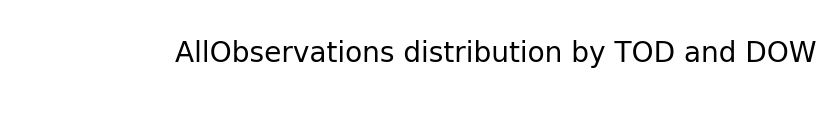

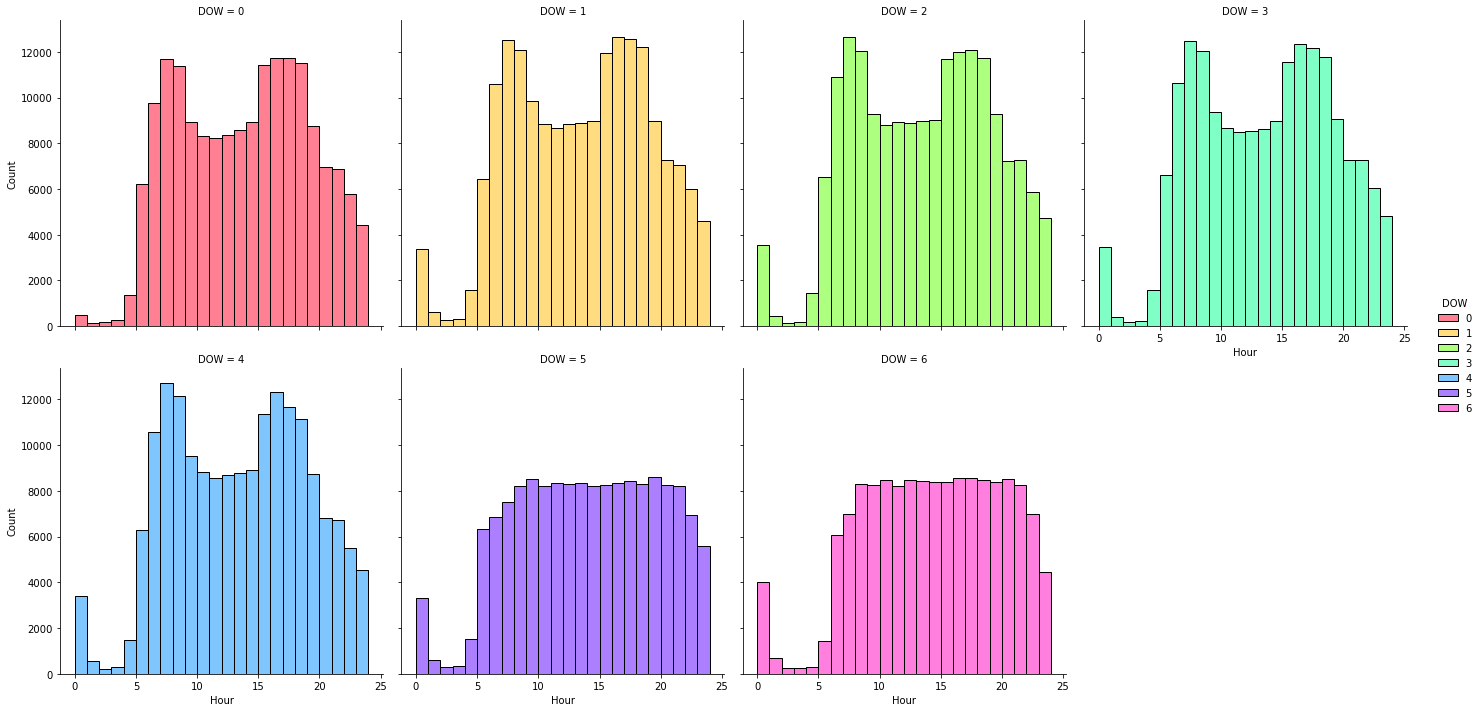

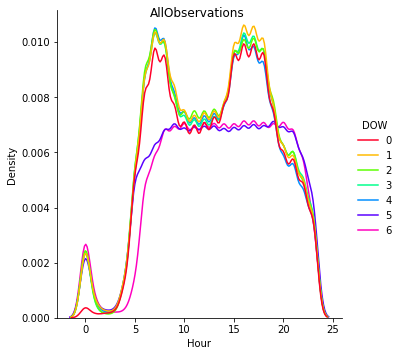

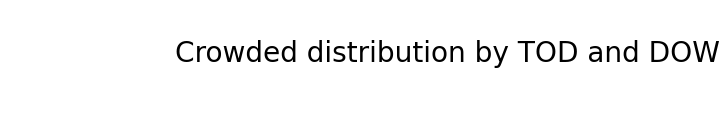

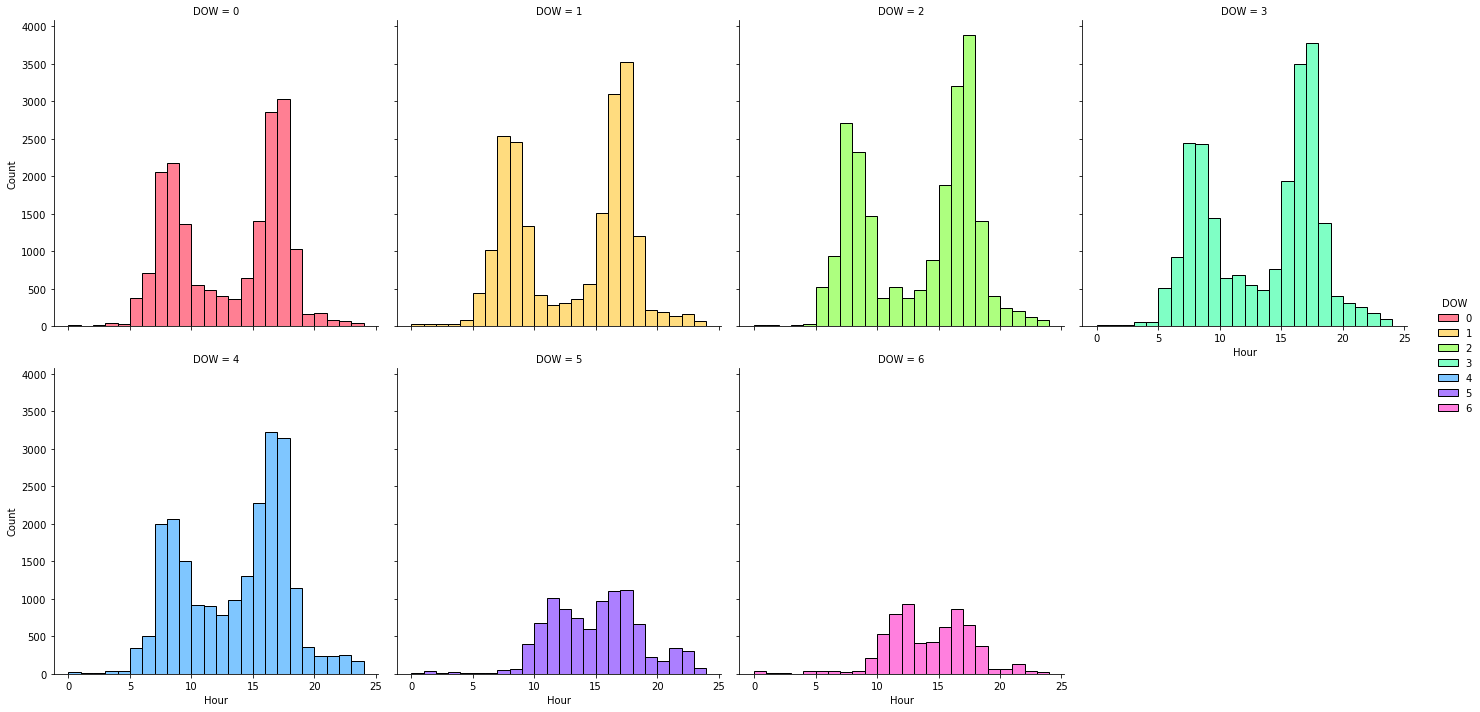

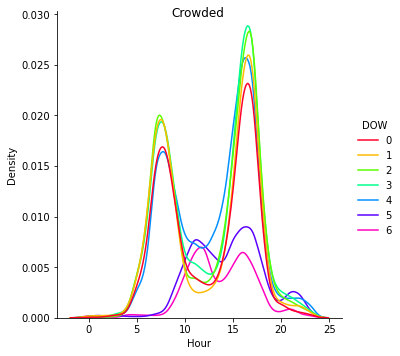

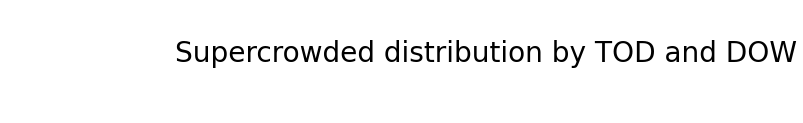

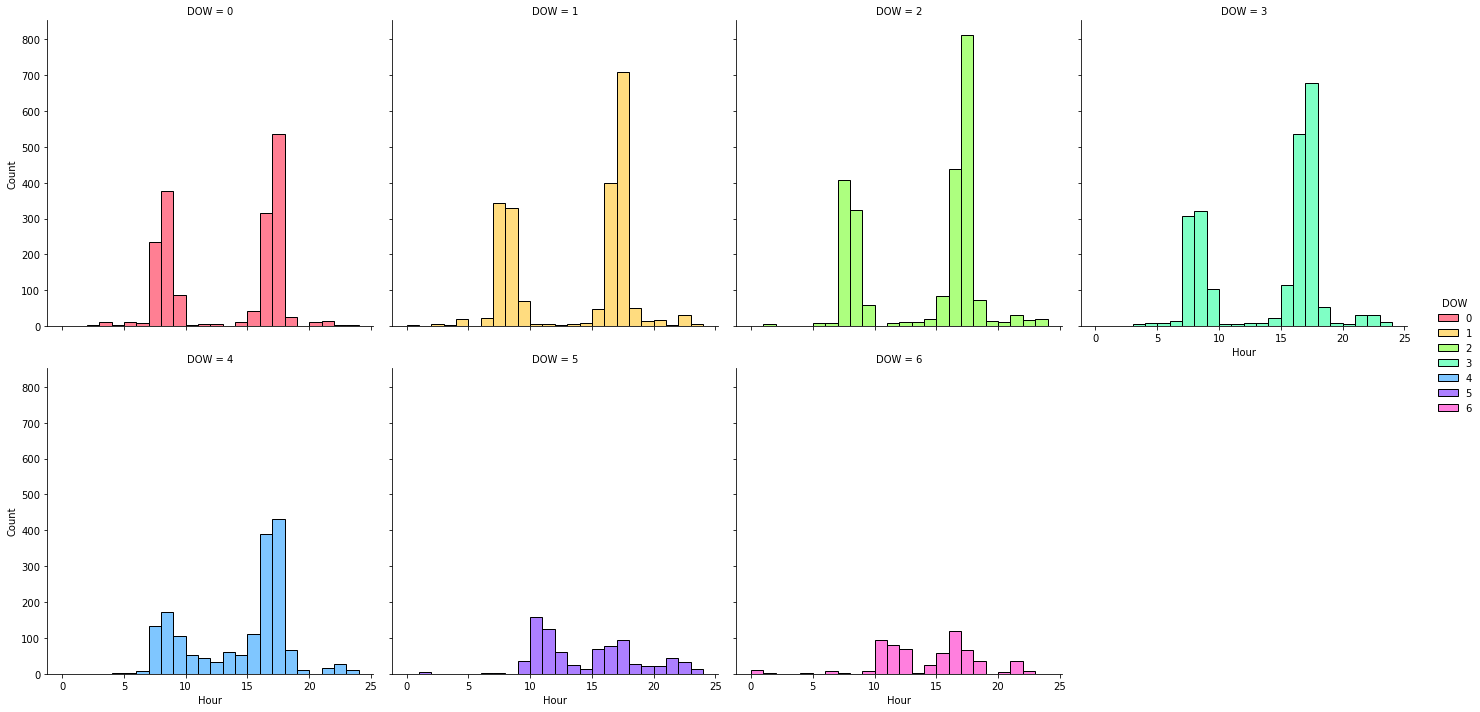

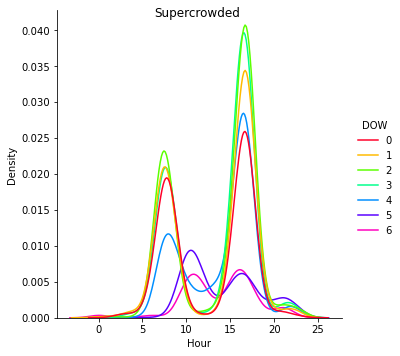

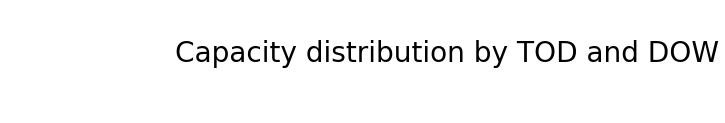

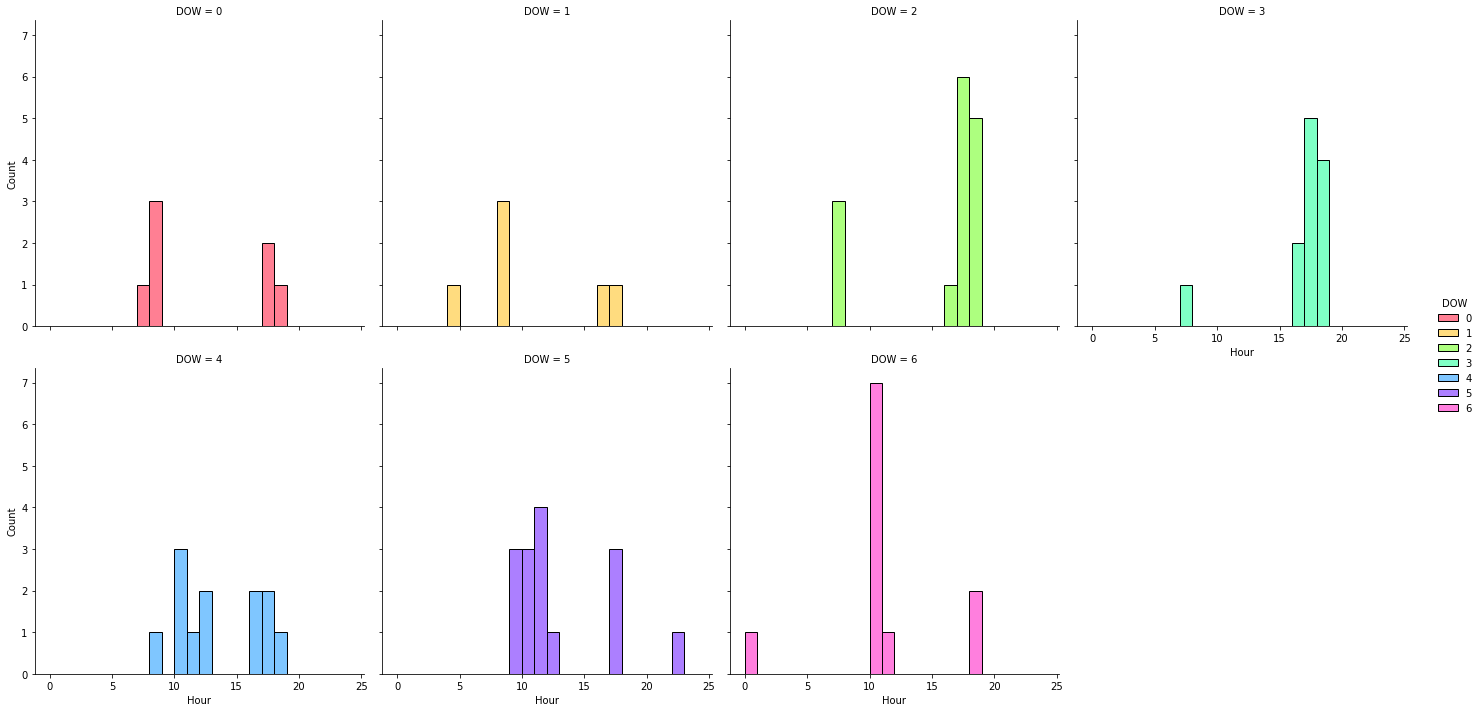

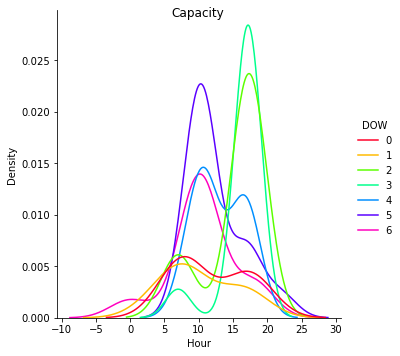

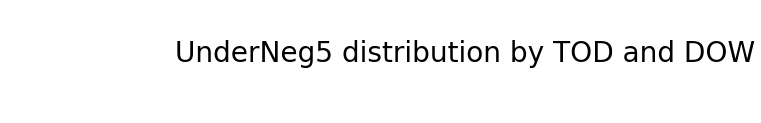

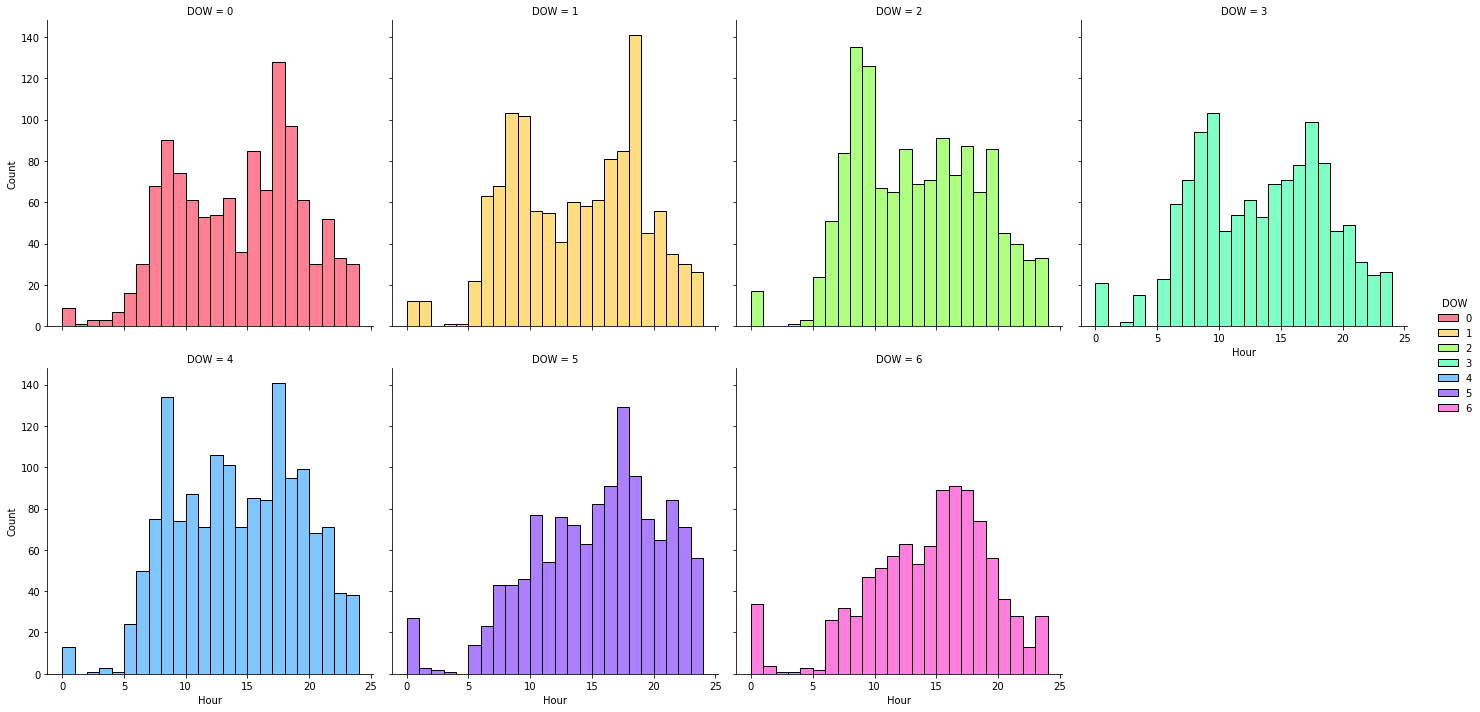

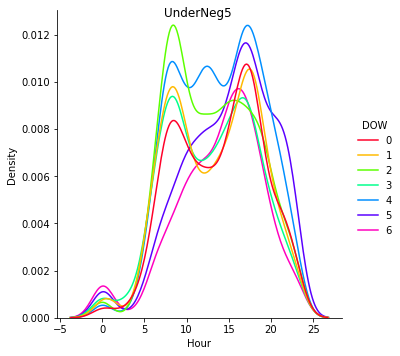

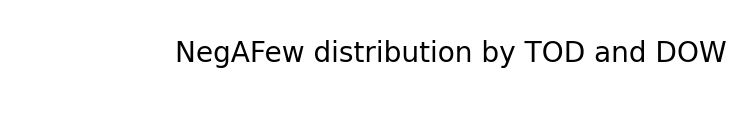

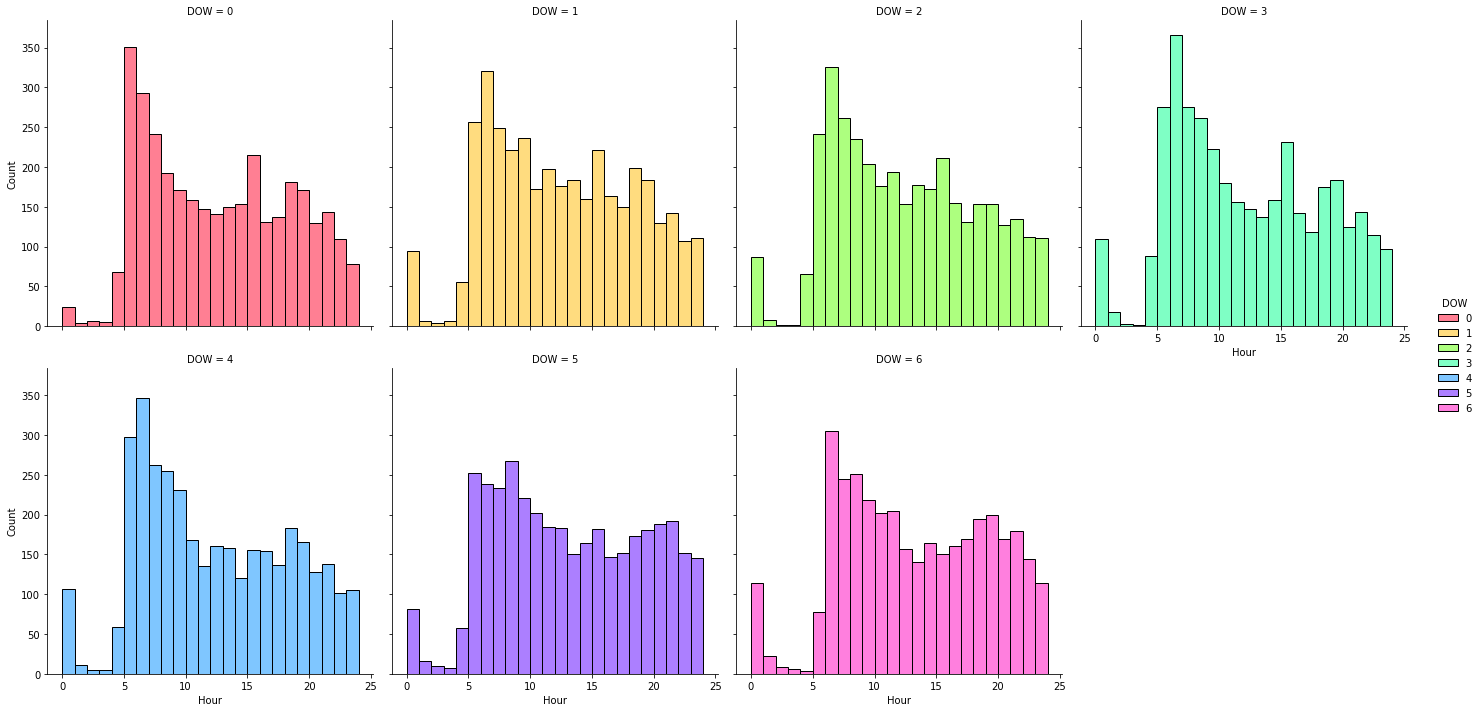

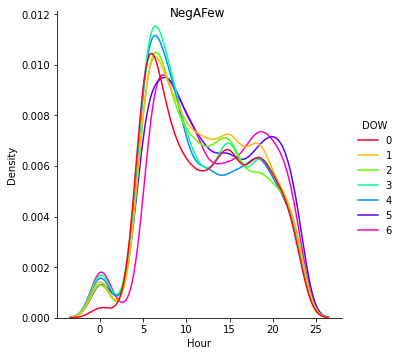

In [13]:
df = df04

ofinterest = ['AllObservations','Crowded','Supercrowded','Capacity','UnderNeg5','NegAFew']

for col in ofinterest:
    plt.subplots(figsize=(6, 2))
    plt.text(0.5, 0.5, col+' distribution by TOD and DOW', fontsize=28)
    plt.axis('off')
    b = sns.displot(x=df.loc[df[col],'Hour'], col=df.loc[df[col],'DOW'],
                binwidth=1, binrange=[0,24], hue=df.loc[df[col],'DOW'], palette='gist_rainbow', col_wrap=4)
    c = sns.displot(x=df.loc[df[col],'Hour'], hue=df.loc[df[col],'DOW'],
                kind='kde', palette='gist_rainbow').fig.suptitle(col)

C:\Users\augus\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


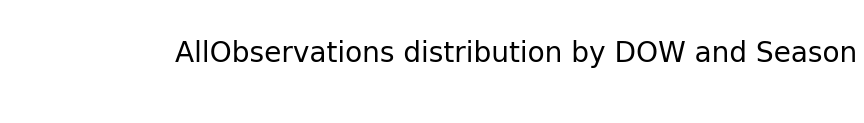

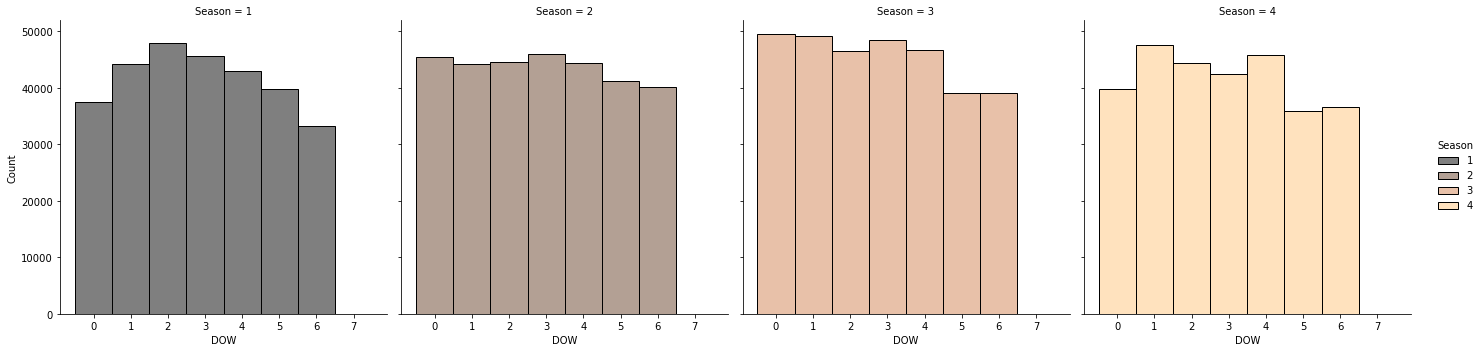

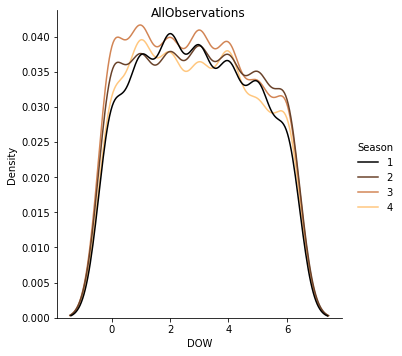

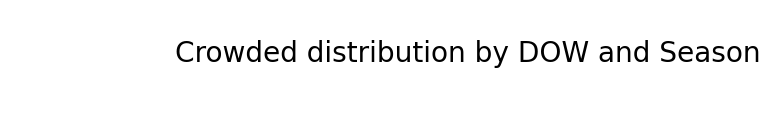

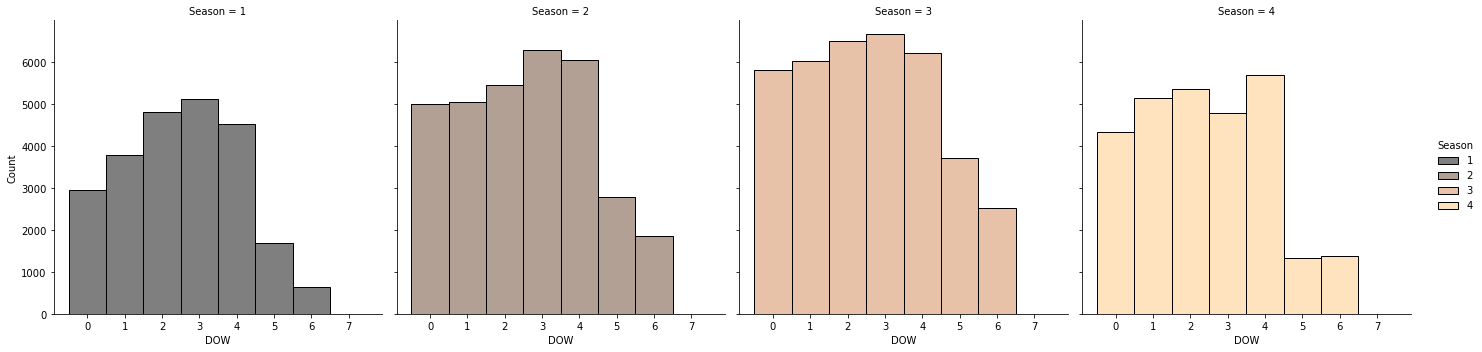

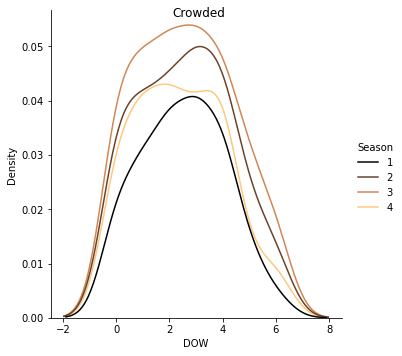

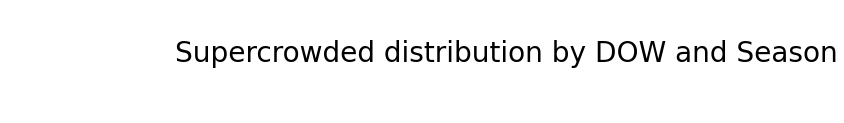

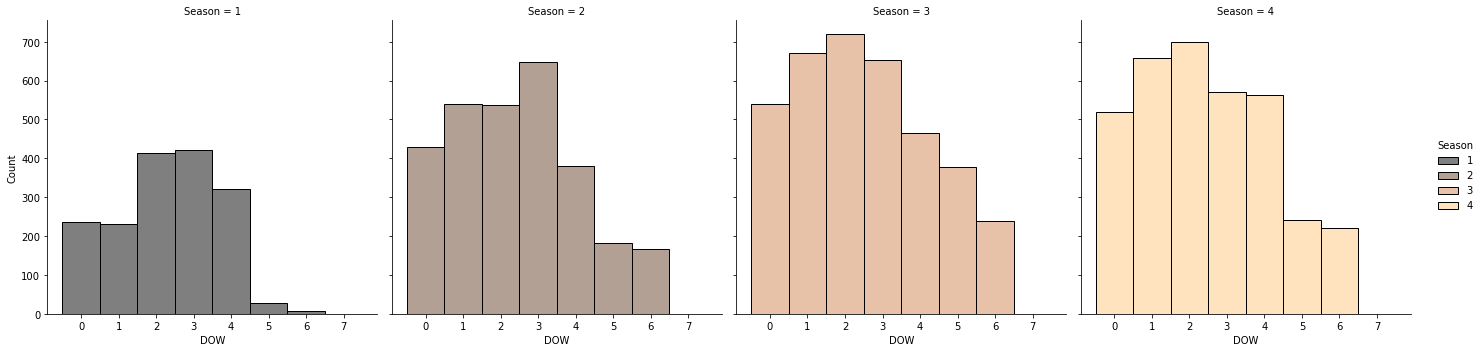

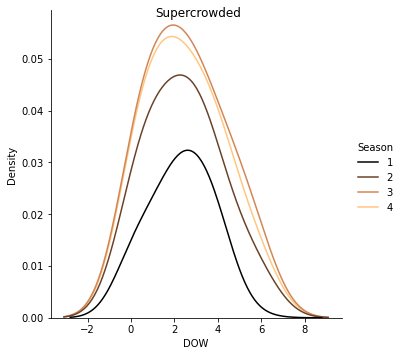

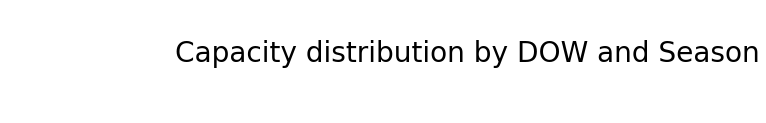

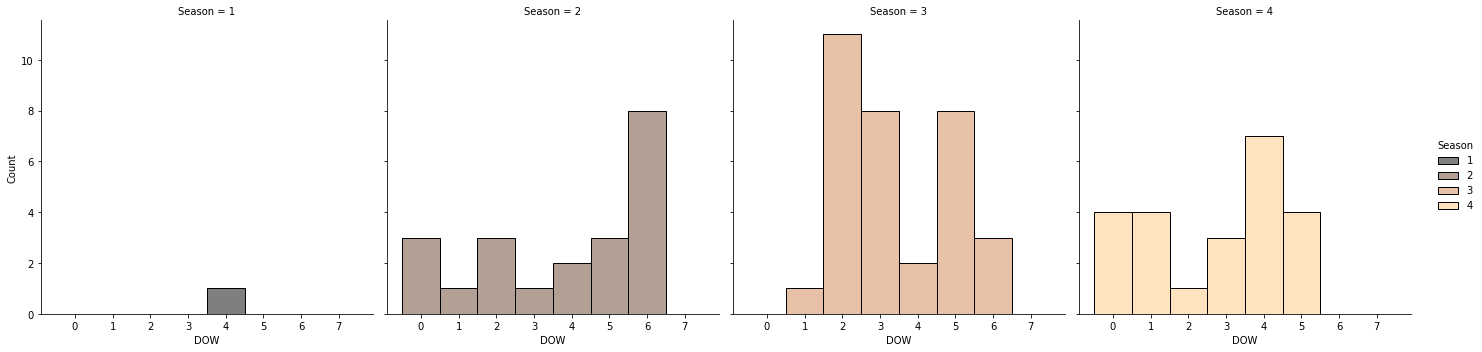

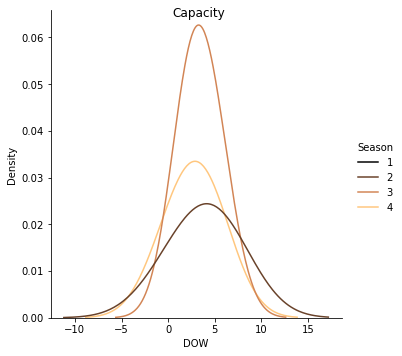

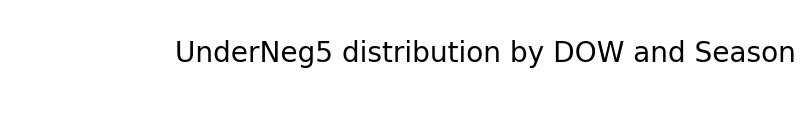

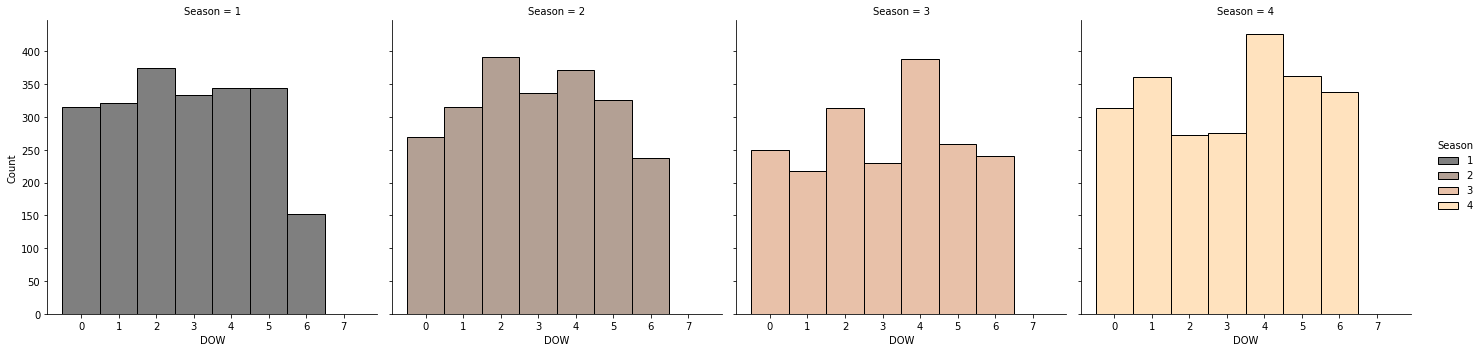

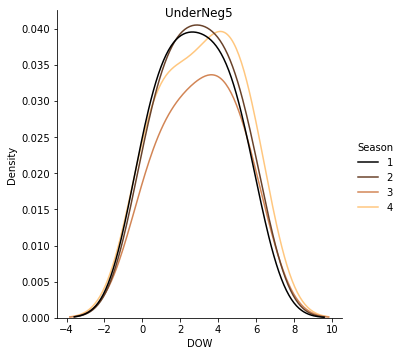

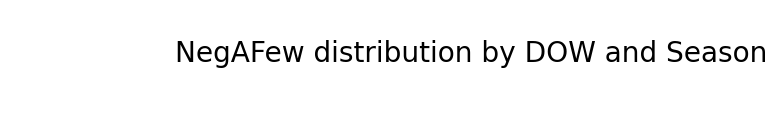

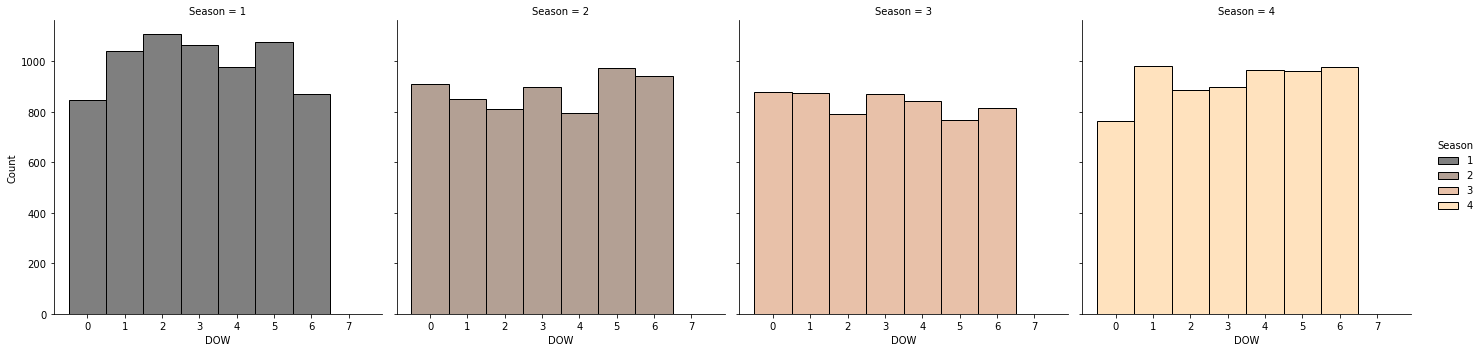

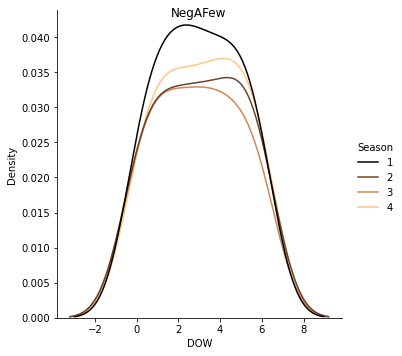

In [14]:
df = df04

ofinterest = ['AllObservations','Crowded','Supercrowded','Capacity','UnderNeg5','NegAFew']

for col in ofinterest:
    plt.subplots(figsize=(6, 2))
    plt.text(0.5, 0.5, col+' distribution by DOW and Season', fontsize=28)
    plt.axis('off')
    b = sns.displot(x=df.loc[df[col],'DOW'], col=df.loc[df[col],'Season'],
                    binwidth=1, binrange=[0,7], hue=df.loc[df[col],'Season'],
                    discrete=True,
                    palette = 'copper',
                    col_wrap=4)
    c = sns.displot(x=df.loc[df[col],'DOW'], hue=df.loc[df[col],'Season'],
                    kind='kde', bw_adjust = 3,
                    palette='copper').fig.suptitle(col)

## Train-test split

In [15]:
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

## Removing seasonal trend (sine/cosine curve)

Below, I remove the year-period seasonal trend. This tells us something about the data, but I haven't used this information in predictive models yet.


The week-period trend has a different shape than a sine curve - should I remove a different-shaped curve? Haven't tried this yet.

Let's get started. Find the mean crowdedness by day (agnostic of station or of hour)

In [16]:
pw_agg_doy = df04_train.groupby(['DOY'])['passwithin'].mean()

cr_agg_doy = df04_train.groupby(['DOY'])['Crowded'].mean()

pw_agg_woy = df04_train.groupby(['WOY'])['passwithin'].mean()

cr_agg_woy = df04_train.groupby(['WOY'])['Crowded'].mean()

In [19]:
def sinu(x, a, c, d):
    b = 6.28/52 # forces the period to be 1 year)
    return a * np.sin(b * (x - c)) + d

params, params_covariance = optimize.curve_fit(sinu, pw_agg_woy.index, pw_agg_woy,
                                               p0=[3, 13, 33])

Text(0.5, 0, 'Week of year')

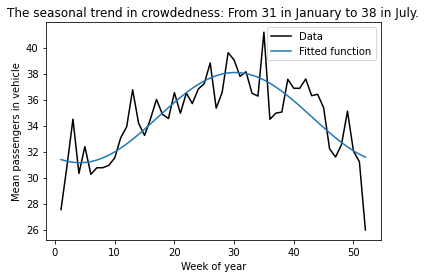

In [26]:
x_data = pw_agg_woy.index
y_data = pw_agg_woy
y_sinu_year = pd.Series(data=sinu(x_data, params[0], params[1], params[2]),
                   index=x_data)


plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', c='black')
plt.plot(x_data, y_sinu_year,
         label='Fitted function')
plt.title('The seasonal trend in crowdedness: From 31 in January to 38 in July.')
plt.legend(loc='best')
plt.ylabel('Mean passengers in vehicle')
plt.xlabel('Week of year')


In [27]:
pw_agg_woy.name = 'WkMeanPassw'
y_sinu_year.name = 'Sinu01Passw'

Now plot the daily crowdedness minus the year-period curve.

Need to first get a reference table of which year corresponds to which day...

In [28]:
ref = df04[['DOY','WOY']].drop_duplicates(['DOY','WOY'])
ref = ref.set_index('DOY')

In [29]:
byday = ref.copy()
byday['DayMeanPassw'] = pw_agg_doy

In [30]:
byday = byday.join(pw_agg_woy, on='WOY')
byday = byday.join(y_sinu_year, on='WOY')

In [31]:
byday['Removed01'] = byday['DayMeanPassw'] - byday['Sinu01Passw']

Text(0.5, 1.0, 'After removing the year-period trend, a week-period cycle remains.')

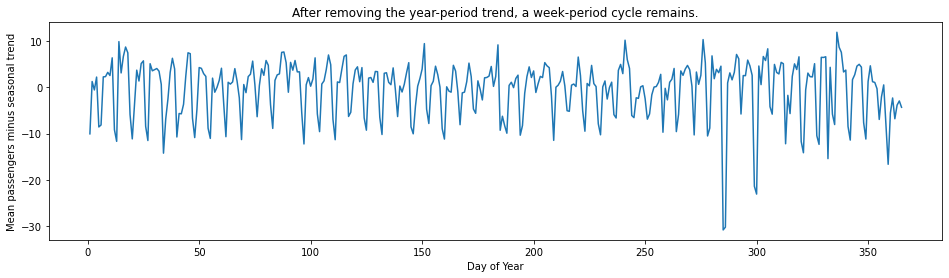

In [34]:
plt.figure(figsize=(16,4))
plt.plot(byday['Removed01'])
plt.xlabel('Day of Year')
plt.ylabel('Mean passengers minus seasonal trend')
plt.title('After removing the year-period trend, a week-period cycle remains.')

##### Come back to the below later...

- I started to remove a week-period sinusoidal trend, but then I decided that wasn't appropriate.

def sinu(x, a, c, d):
    b = 6.28/7 # forces the period to be 1 week
    return a * np.sin(b * (x - c)) + d

params, params_covariance = optimize.curve_fit(sinu, byday.index, byday['Removed01'],
                                               p0=[, 98, 0])

x_data = pw_agg_woy.index
y_data = pw_agg_woy
y_sinu_year = pd.Series(data=sinu(x_data, params[0], params[1], params[2]),
                   index=x_data)


plt.figure(figsize=(6, 4))
plt.plot(x_data, y_data, label='Data', c='black')
plt.plot(x_data, y_sinu_year,
         label='Fitted function')

plt.legend(loc='best')

pw_agg_woy.name = 'WkMeanPassw'
cw_agg_woy.name = 'WkAvgCrowded'


#### Create all these variables in df04_train

In [39]:
df05_train = df04_train.join(y_sinu_year, on='WOY')  # column name 'Sinu01Passw'
df05_train['Removed01'] = df05_train['passwithin'] - df05_train['Sinu01Passw']

df05_train has all the same observations as df04_train, just with two extra features.
- 'Sinu01Passw' is the year-period sinu curve for passwithin
- 'Removed01' is the actual passwithin minus the sinu curve value of that week.

## Perform PC-Analysis

### PCA on stations

In [46]:
# Group passwithin by Hour, DOY, and station (stadir_ID). Take the mean
pw_agg = df04_train.groupby(['Hour','DOY','stadir_ID'])['passwithin'].mean()

In [47]:
station_view = pw_agg.reset_index().pivot(index='stadir_ID', columns=['DOY','Hour']).sort_index(axis=1, level='DOY')

In [48]:
station_view.head(3)

passwithin                                                    \
DOY              1                                                       
Hour              0     1   2     3   5         6         7         8    
stadir_ID                                                                
101             -0.5 -14.0 NaN -14.0 NaN -4.000000 -0.333333 -0.142857   
102              0.0   NaN NaN   NaN NaN  5.333333  3.000000  3.000000   
201              9.0  -3.6 NaN   NaN NaN  1.500000  3.500000  4.166667   

                                ...                                         \
DOY                             ...        365                               
Hour              9         10  ...         14     15    16   17        18   
stadir_ID                       ...                                          
101         1.000000 -2.666667  ...   9.000000   0.25  -1.6 -1.0 -8.000000   
102        12.000000  3.500000  ...  13.666667   5.75  12.5  3.0  4.333333   
201         7.333333  5.200000  ...  12.000000  10.50  10.0  8.0 -1.400000   

                                                       
DOY                                                    
Hour         19         20         21         22   23  
stadir_ID                                              
101         6.0   0.000000   5.333333  -5.000000  1.0  
102        20.5  10.666667  13.500000  13.666667  5.0  
201         6.0   5.000000  12.333333   9.000000  NaN  

[3 rows x 8002 columns]

In [49]:
station_view.isna().sum().sum()

23372

In [50]:
station_view.shape[0] * station_view.shape[1]

256064

About 8% of entries in this matrix are NaN.

In [51]:
# Try filling NaNs with 0
station_view_fill0 = station_view.fillna(0)
station_view_fill0.head(3)

passwithin                                                      \
DOY              1                                                         
Hour              0     1    2     3    5         6         7         8    
stadir_ID                                                                  
101             -0.5 -14.0  0.0 -14.0  0.0 -4.000000 -0.333333 -0.142857   
102              0.0   0.0  0.0   0.0  0.0  5.333333  3.000000  3.000000   
201              9.0  -3.6  0.0   0.0  0.0  1.500000  3.500000  4.166667   

                                ...                                         \
DOY                             ...        365                               
Hour              9         10  ...         14     15    16   17        18   
stadir_ID                       ...                                          
101         1.000000 -2.666667  ...   9.000000   0.25  -1.6 -1.0 -8.000000   
102        12.000000  3.500000  ...  13.666667   5.75  12.5  3.0  4.333333   
201         7.333333  5.200000  ...  12.000000  10.50  10.0  8.0 -1.400000   

                                                       
DOY                                                    
Hour         19         20         21         22   23  
stadir_ID                                              
101         6.0   0.000000   5.333333  -5.000000  1.0  
102        20.5  10.666667  13.500000  13.666667  5.0  
201         6.0   5.000000  12.333333   9.000000  0.0  

[3 rows x 8002 columns]

Visualize NaNs by hour:

In [53]:
# "By Hour, how many DOY-stadir combos don't exist?"
pw_agg = df04_train.groupby(['Hour','DOY','stadir_ID'])['passwithin'].mean()

Goal: figure out which hours have very few observations.

Below we see that there are very few DOW-stadir combos that have any observations in the 1:00, 2:00 or 3:00 hours. It's also rather scarce in the 4:00 hour.

Because of this, I will remove the 1am thru 4am hours. This way, the station_view dataframe will have much fewer NaNs.

In [54]:
dfo = pd.DataFrame({'Hour':[x[0] for x in pw_agg.index],
                    'DOW':[x[1] for x in pw_agg.index],
                    'stadir_ID':[x[2] for x in pw_agg.index]})
dfo.groupby('Hour').count()

DOW  stadir_ID
Hour                  
0      8160       8160
1      1960       1960
2      1040       1040
3      1116       1116
4      4716       4716
5     10184      10184
6     11394      11394
7     11487      11487
8     11530      11530
9     11502      11502
10    11494      11494
11    11487      11487
12    11513      11513
13    11522      11522
14    11520      11520
15    11558      11558
16    11531      11531
17    11486      11486
18    11500      11500
19    11449      11449
20    11357      11357
21    11380      11380
22    11163      11163
23    10643      10643

Remove 1 o'clock hour thru 4 o'clock hour:

In [55]:
hour = pd.Series(data=[x[2] for x in station_view.columns],
                 index=station_view.columns)
filt = ~hour.between(1,4)

# Station view
station_view_filt = station_view.loc[:,filt]

Fill NaNs by interpolating:

In [56]:
# Fill NaNs by interpolating before and after
station_view_ipl = station_view_filt.interpolate(method='linear', axis=1)
station_view_ipl.head(3)

passwithin                                                     \
DOY              1                                                        
Hour              0         5         6         7         8          9    
stadir_ID                                                                 
101             -0.5 -2.250000 -4.000000 -0.333333 -0.142857   1.000000   
102              0.0  2.666667  5.333333  3.000000  3.000000  12.000000   
201              9.0  5.250000  1.500000  3.500000  4.166667   7.333333   

                                              ...                          \
DOY                                           ...        365                
Hour             10        11        12   13  ...         14     15    16   
stadir_ID                                     ...                           
101       -2.666667  1.333333 -1.200000 -1.5  ...   9.000000   0.25  -1.6   
102        3.500000  7.750000  8.200000  5.0  ...  13.666667   5.75  12.5   
201        5.200000  3.500000  2.714286  1.5  ...  12.000000  10.50  10.0   

                                                                      
DOY                                                                   
Hour        17        18    19         20         21         22   23  
stadir_ID                                                             
101       -1.0 -8.000000   6.0   0.000000   5.333333  -5.000000  1.0  
102        3.0  4.333333  20.5  10.666667  13.500000  13.666667  5.0  
201        8.0 -1.400000   6.0   5.000000  12.333333   9.000000  9.0  

[3 rows x 7288 columns]

Do PCA on the interpolation-filled df:

In [57]:
pca01 = PCA(n_components=0.95, svd_solver='full')

station_pc = pca01.fit_transform(station_view_ipl)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [58]:
#station_pc
pca01.explained_variance_ratio_

array([0.44158736, 0.39263624, 0.04199495, 0.02983978, 0.01549915,
       0.00817071, 0.00638198, 0.0059527 , 0.00536735, 0.00430558])

In [ ]:
plt.plot(pca01.explained_variance_ratio_)

We have 44% of variance explained by the first PC, and 39% of variance explained by the second PC. Then it goes 4%, 3%, 2%, 1%...

<AxesSubplot:>

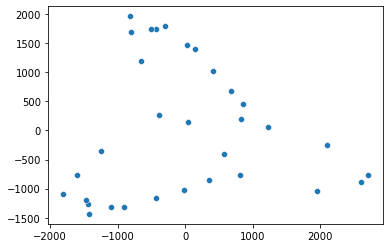

In [59]:
sns.scatterplot(x=station_pc[:,0], y= station_pc[:,1])

Such an interesting shape! Call it a butterfly.

What this means is that the stations don't naturally cluster into a couple types. But let's investigate this butterfly pattern further...

In [66]:
# day_pc_investigation

station_pci = pd.DataFrame(data=station_pc[:,[0,1]], index=station_view.index, columns=['PC1','PC2'])

df = station_pci
northbound = [102,203,304,405,506,607,708,809,910,1011,1112,1213,1314,1415,1516,1616]

df['Northbound'] = np.where(df.index.isin(northbound), 1, 0)

df['ID'] = df.index

df['RouteProgress']= np.where(df['Northbound'],
                             np.round(df['ID'],-2)//100,
                             np.round(1700-df['ID'],-2)//100)

df['Station'] = np.round(df['ID'],-2)//100

df

PC1          PC2  Northbound    ID  RouteProgress  Station
stadir_ID                                                                    
101        2705.453104  -772.615413           0   101             16        1
102        1959.477314 -1041.345968           1   102              1        1
201        2103.972703  -250.251841           0   201             15        2
203         815.870148  -761.306741           1   203              2        2
302        1222.990035    66.060693           0   302             14        3
304         358.578858  -852.108610           1   304              3        3
403         852.628863   457.057943           0   403             13        4
405          -9.654305 -1015.279566           1   405              4        4
504         677.030346   683.504320           0   504             12        5
506        -431.855143 -1162.002149           1   506              5        5
605         415.328592  1029.710994           0   605             11        6
607        -911.501595 -1319.056445           1   607              6        6
706         147.048599  1395.180928           0   706             10        7
708       -1098.829600 -1307.411908           1   708              7        7
807          24.369929  1478.464755           0   807              9        8
809       -1423.144490 -1434.420430           1   809              8        8
908        -294.388568  1796.384585           0   908              8        9
910       -1432.930142 -1266.164377           1   910              9        9
1009       -434.348314  1752.779150           0  1009              7       10
1011      -1463.581868 -1191.516038           1  1011             10       10
1110       -510.106545  1741.835737           0  1110              6       11
1112      -1805.713438 -1086.450980           1  1112             11       11
1211       -815.540364  1964.460992           0  1211              5       12
1213      -1609.044163  -764.055600           1  1213             12       12
1312       -808.436757  1689.121946           0  1312              4       13
1314      -1245.213045  -357.136797           1  1314             13       13
1413       -649.227875  1197.611212           0  1413              3       14
1415       -383.139733   268.661224           1  1415             14       14
1514         41.066716   153.809073           0  1514              2       15
1516        573.186174  -398.779787           1  1516             15       15
1615        826.682867   195.236992           0  1615              1       16
1616       2602.971696  -889.977895           1  1616             16       16

Text(0.5, 1.0, 'Stations in PC-space')

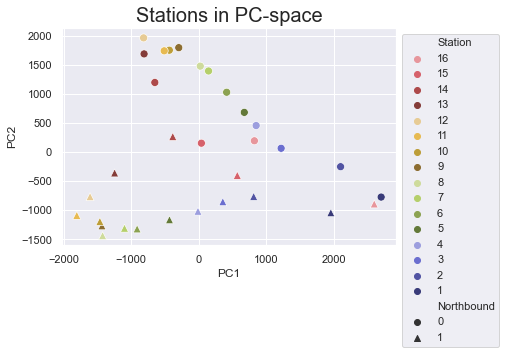

In [70]:
sns.set_theme()
ax = sns.scatterplot(data=station_pci, x='PC1', y='PC2', hue='Station',
                     style='Northbound', 
                     markers=('o','^'),
                     alpha=1,
                     palette='tab20b',
                     s=64)
handles, labels = ax.get_legend_handles_labels()
legend_order = [0,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,17,18,19]
handles_lo = [handles[x] for x in legend_order]
labels_lo = [labels[x] for x in legend_order]
ax.legend(handles_lo, labels_lo)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))
plt.title('Stations in PC-space', size=20)

The stations follow the shape mostly in station order but not completely!

The train route traces the (lower-)left wing of the butterfly going Northbound, and traces the (upper-)right wing of the butterfly going Southbound. In this PC-space, stations 15 and 16 are closer to stations 1,2,3, and 4 - and stations 15 and 16 are against the body of the butterfly.

Let's look at the PC loadings to know what's going on:

In [73]:
loadings = pd.DataFrame(pca01.components_[:2].T, columns=['PC1', 'PC2'], index=station_view_ipl.columns)

In [79]:
loadings.sort_values('PC1')

PC1       PC2
           DOY Hour                    
passwithin 181 10   -0.035932 -0.030334
           309 8    -0.034010 -0.022471
           292 10   -0.032917 -0.039308
               11   -0.031876 -0.030624
           243 10   -0.031830 -0.043968
...                       ...       ...
           303 0     0.000821  0.001285
           283 0     0.000963  0.000700
           311 0     0.001129  0.003326
           205 0     0.001266  0.003053
           163 19    0.001679  0.029854

[7288 rows x 2 columns]

In [75]:
loadings.sort_values('PC2')

PC1       PC2
           DOY Hour                    
passwithin 243 10   -0.031830 -0.043968
           292 10   -0.032917 -0.039308
           243 9    -0.024982 -0.036622
           333 10   -0.026938 -0.033413
           243 11   -0.030303 -0.031838
...                       ...       ...
           268 17   -0.011759  0.039071
           319 16   -0.009511  0.039390
           330 17   -0.014446  0.039622
           331 16   -0.007240  0.046043
           256 21   -0.003866  0.049196

[7288 rows x 2 columns]

Based on the top 5 and bottom 5 DOY-Hour combos for each PC, we can paint a vignette:

Positive PC1: late-night midweek -ness
Negative PC1: weekend morning -ness
Positive PC2: weekday evening rush-hour -ness  
Negative PC2: weekend morning -ness

Higher values of PC1 happen when weekend mornings are less crowded and midweek late-nights are more crowded.

Higher values of PC2 happen when weekend mornings are less crowded and weekday evening rush-hours are more crowded.

Looking back at the plot:
- Higher values of PC1 happen at the first couple and last couple stations, i.e. the northernmost and southernmost stations, i.e. the outer stations. Lower values of PC1 happen in the middle of the trip, applying to most of the stations, i.e. the city center.
- Higher values of PC2 happen for Southbound, especially for Southbound city center stations. Lower values happen for most Northbound stations.

Conclusions from plot:
- PC1 mostly captures city center stations versus outer stations.
- PC2 mostly captures Northbound vs Southbound.

Conclusions from loadings:
  - (from PC2) On weekend mornings, Northbound stops may be more crowded than Southbound.
  - (from PC1) On weekend mornings, city center stops may be more crowded than outer stops.
  - (from PC2) On weekday 4-6pm times, Southbound stops may be more crowded than Northbound stops.
  - (from PC1) On weekday late-nights, outer stops may be more crowded than city center stops.
    - This is explained by the the airport stop and the college stop at either end - both would spur late-night crowds!


### PCA on days.

In [80]:
day_view = pw_agg.reset_index().pivot(index='DOY', columns=['Hour','stadir_ID'])

In [81]:
day_view.isna().sum().sum()

47628

In [82]:
day_view.shape[0] * day_view.shape[1]

280320

About 15% of entries in this matrix are NaN.

In [83]:
# Try filling NaNs with 0
day_view_fill0 = day_view.fillna(0)

In [84]:
pca02 = PCA(n_components=0.7, svd_solver='full')

day_pc = pca02.fit_transform(day_view_fill0)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [85]:
#station_pc
pca02.explained_variance_ratio_

array([0.32673617, 0.09220658, 0.05595519, 0.03488235, 0.02621848,
       0.01991014, 0.01727938, 0.01461438, 0.01431709, 0.01355396,
       0.0116944 , 0.01084389, 0.01049458, 0.00953156, 0.00887304,
       0.00873738, 0.00811739, 0.00752609, 0.00741083, 0.00687921])

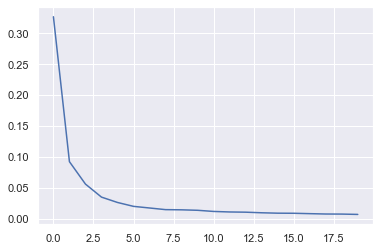

In [86]:
plt.plot(pca02.explained_variance_ratio_)

33% of variance expliained by first PC, then 9% by second PC, then 6%, then 3%. then 3%, 2%, 2%...

I think the natural cutoff is to think of this as essentially 3-dimensional. Maybe 2-dimensional is better though.

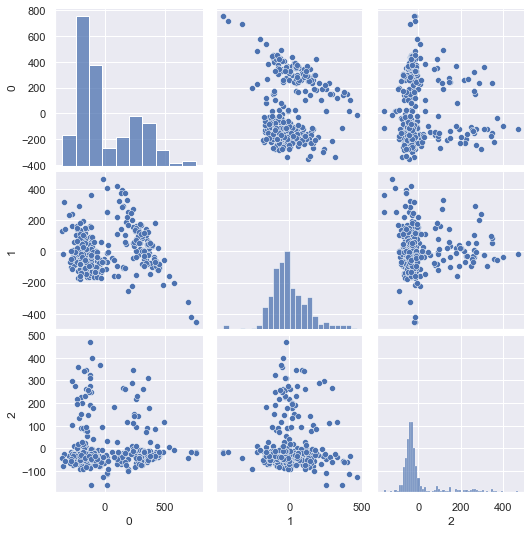

In [87]:
sns.pairplot(pd.DataFrame(day_pc[:,[0,1,2]]))

Next steps: choose a clustering method that captures the two by-eye-visible clusters; then figure out what aspect of each point makes it belong to a particular cluster versus the other.

### Clustering for Day PCA

- TODO: Fix colors, they look awful right now

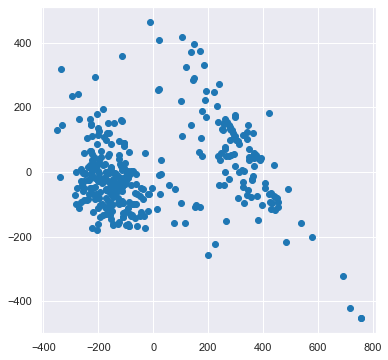

In [134]:
plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1])

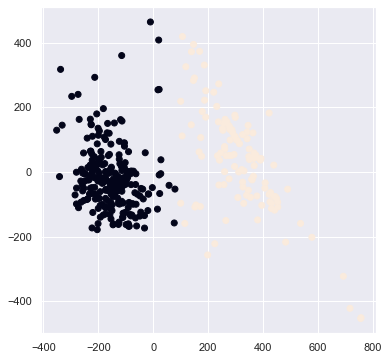

In [135]:
kmeans = KMeans(n_clusters = 2)

labels = kmeans.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

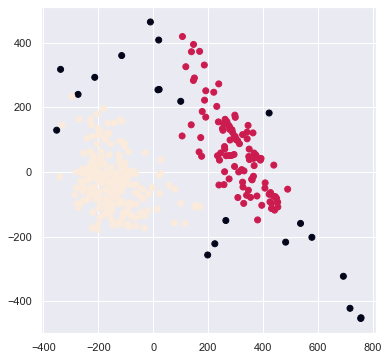

In [136]:
std = np.std(day_pc[:,[0,1]])

dbscan = DBSCAN(eps = std * 0.4) # 0.4 std was the best I could find
# DBSCAN is really not the best for this problem

labels = dbscan.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

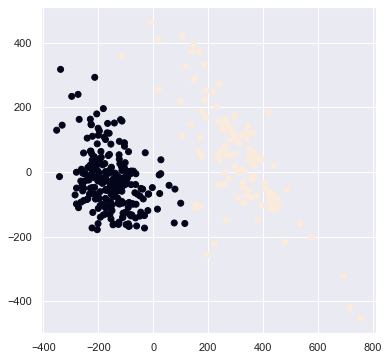

In [137]:
gmm = GaussianMixture(n_components=2, covariance_type='full')

labels = gmm.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

In [138]:
dates2019 = pd.date_range("2019-01-01", periods=365, freq="D")

In [139]:
# day_pc_investigation

day_pci = pd.DataFrame(data=day_pc[:,[0,1]], index=dates2019, columns=['PC1','PC2'])

In [140]:
cal = USFederalHolidayCalendar()

In [141]:
day_pci['Holiday'] = day_pci.index.isin(cal.holidays())

In [142]:
day_pci['DayName'] = day_pci.index.day_name()

In [143]:
day_pci['GMM_Label'] = labels

In [144]:
day_pci

PC1         PC2  Holiday    DayName  GMM_Label
2019-01-01  490.275316  -53.000003     True    Tuesday          1
2019-01-02   -2.964969  -48.123159    False  Wednesday          0
2019-01-03   23.803727  -66.486044    False   Thursday          0
2019-01-04   28.246600   37.848837    False     Friday          0
2019-01-05  365.668706  -13.013612    False   Saturday          1
...                ...         ...      ...        ...        ...
2019-12-27  167.387871   62.048721    False     Friday          1
2019-12-28  374.024977   52.856909    False   Saturday          1
2019-12-29  326.077150  115.561285    False     Sunday          1
2019-12-30  115.423423 -159.015621    False     Monday          0
2019-12-31  258.133809  -38.985578    False    Tuesday          1

[365 rows x 5 columns]

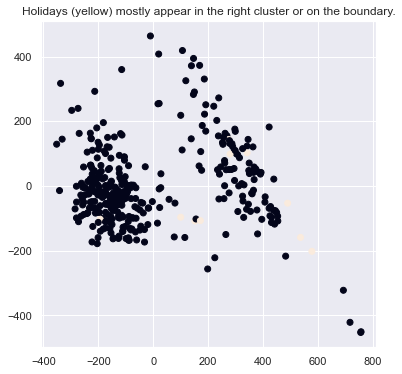

In [145]:
plt.figure(figsize=(6,6))
plt.title('Holidays (yellow) mostly appear in the right cluster or on the boundary.')
plt.scatter(day_pci['PC1'], day_pci['PC2'], c=day_pci['Holiday'])

Note 8/8: colors got messed up for these plt plots.

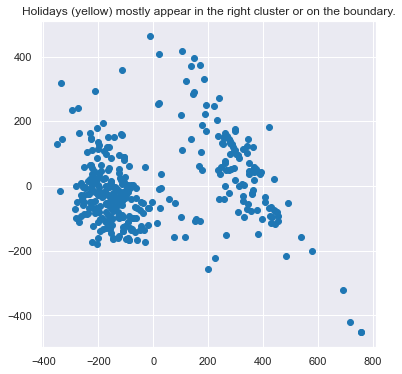

In [148]:
plt.figure(figsize=(6,6))
plt.title('Holidays (yellow) mostly appear in the right cluster or on the boundary.')
plt.scatter(day_pci['PC1'], day_pci['PC2'], cmap=day_pci['DayName'])

Use seaborn:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

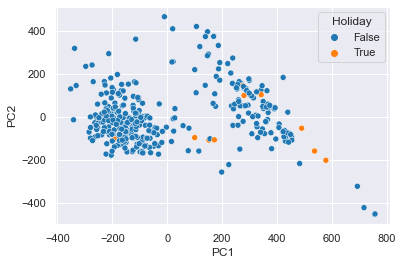

In [149]:
sns.scatterplot(data=day_pci, x='PC1', y='PC2', hue='Holiday')

Holidays mostly appear in the right cluster or on the boundary.

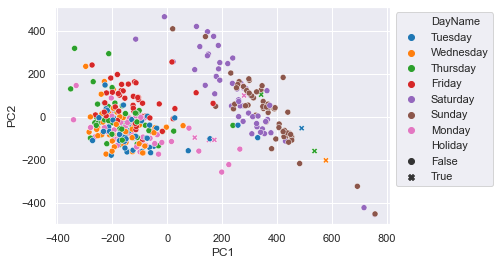

In [150]:
ax = sns.scatterplot(data=day_pci, x='PC1', y='PC2', hue='DayName', style='Holiday')
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))

Aha!

We immediately see a Saturday-Sunday-holiday-dominated cluster on the right, and a weekday-dominated cluster on the left.

Below I investigate the weekdays of the right-hand cluster:

In [151]:
df = day_pci

df[(df['DayName'].isin(['Friday','Monday'])) & (~df['GMM_Label'])].sort_values('DayName')

PC1         PC2  Holiday DayName  GMM_Label
2019-01-04   28.246600   37.848837    False  Friday          0
2019-05-03 -124.246798   53.347379    False  Friday          0
2019-09-06 -107.046451   89.298063    False  Friday          0
2019-05-10 -123.547904   39.824147    False  Friday          0
2019-05-17 -154.149582   86.203617    False  Friday          0
...                ...         ...      ...     ...        ...
2019-07-29 -137.017117   -6.607874    False  Monday          0
2019-08-05 -144.649110  -26.797590    False  Monday          0
2019-08-12 -220.241473  -67.459075    False  Monday          0
2019-08-26 -203.832486   87.068428    False  Monday          0
2019-12-30  115.423423 -159.015621    False  Monday          0

[94 rows x 5 columns]

Aha! These cluster-0 Fridays are all holiday-like days - July 5th, Black Friday, and Christmas week Friday.

Monday non-holidays are a bit harder to understand. Feb 4 and Feb 11 were snowstorms.

Did some research on Oct 21 and didn't conclude anything. That point was right on the line between the two clusters anyway. Maybe there were enough small things going on to encourage people to take a day off work - day after an NFL game, a film festival, etc.

Check that there are no Sat-Sun days in cluster 1:

In [152]:
df = day_pci

df[(df['DayName'].isin(['Saturday','Sunday'])) & (~df['GMM_Label'])].sort_values('DayName')

Empty DataFrame
Columns: [PC1, PC2, Holiday, DayName, GMM_Label]
Index: []

Yep, that's every Saturday and Sunday.

Investigate Tues-Weds-Thurs days in cluster 0:

In [153]:
df = day_pci

df[(df['DayName'].isin(['Tuesday','Wednesday','Thursday'])) & (~df['GMM_Label'])].sort_values('DayName')

PC1        PC2  Holiday    DayName  GMM_Label
2019-12-19  -16.564444 -68.368135    False   Thursday          0
2019-11-14 -201.439052 -80.833793    False   Thursday          0
2019-04-04 -172.409297 -53.528422    False   Thursday          0
2019-04-11 -139.160399 -63.355850    False   Thursday          0
2019-04-18 -256.729514  -3.508843    False   Thursday          0
...                ...        ...      ...        ...        ...
2019-06-05 -238.099997  14.114432    False  Wednesday          0
2019-05-29 -184.200411  22.078242    False  Wednesday          0
2019-05-22 -118.485633 -26.383658    False  Wednesday          0
2019-07-10 -238.027118 -82.355316    False  Wednesday          0
2019-06-26 -113.553525 -40.372984    False  Wednesday          0

[149 rows x 5 columns]

Feb 12 Snowstorm. Christmas week. That's it.

## Prepare readout functions

### Classic readout function

- does 5-fold CV and prints confusion matrix, as well as precision, recall, f1, and the standard error of each score.

In [40]:
# Code adapted from sklearn user guide 3.3.1.4

def all_inclusive_scorer(clf, X, y):
    print('Starting work on a new fold...')
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    pr = precision_score(y, y_pred)
    re = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
            'precision': pr,
            'recall': re,
            'f1': f1}

In [41]:
def cv_readout(model, X, y):
    print('Performing 5-fold cross-validation...')
    #scores = cross_validate(model, X, y, cv=5, scoring=['precision','recall','f1','confusion_matrix'])
    raw = cross_validate(model, X, y, cv=5, scoring=all_inclusive_scorer)
    print('Aggregating the scores...')
    sum_cm = np.array([[sum(raw['test_tn']), sum(raw['test_fp'])],
                       [sum(raw['test_fn']), sum(raw['test_tp'])]])
    
    agg_scores = pd.DataFrame(index=['precision','recall','f1'],
                              columns=['mean','std'])
    agg_scores.at['precision','mean'] = np.mean(raw['test_precision'])
    agg_scores.at['precision','std'] = np.std(raw['test_precision'])
    agg_scores.at['recall','mean'] = np.mean(raw['test_recall'])
    agg_scores.at['recall','std'] = np.std(raw['test_recall'])
    agg_scores.at['f1','mean'] = np.mean(raw['test_f1'])
    agg_scores.at['f1','std'] = np.std(raw['test_f1'])
    
    print(sum_cm)
    print(agg_scores)
    

### Regression readout function

Not finished yet. Currently is the same as the classification readout - I need to change the scores to be RMSE or similar.

In [42]:
# Code adapted from sklearn user guide 3.3.1.4

def all_inclusive_scorer_r(reg, X, y):
    print('Starting work on a new fold...')
    y_pred = reg.predict(X)
    cm = confusion_matrix(y, y_pred)
    pr = precision_score(y, y_pred)
    re = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
            'precision': pr,
            'recall': re,
            'f1': f1}

In [43]:
def cv_readout_r(model, X, y):
    print('Performing 5-fold cross-validation...')
    #scores = cross_validate(model, X, y, cv=5, scoring=['precision','recall','f1','confusion_matrix'])
    raw = cross_validate(model, X, y, cv=5, scoring=all_inclusive_scorer)
    print('Aggregating the scores...')
    sum_cm = np.array([[sum(raw['test_tn']), sum(raw['test_fp'])],
                       [sum(raw['test_fn']), sum(raw['test_tp'])]])
    
    agg_scores = pd.DataFrame(index=['precision','recall','f1'],
                              columns=['mean','std'])
    agg_scores.at['precision','mean'] = np.mean(raw['test_precision'])
    agg_scores.at['precision','std'] = np.std(raw['test_precision'])
    agg_scores.at['recall','mean'] = np.mean(raw['test_recall'])
    agg_scores.at['recall','std'] = np.std(raw['test_recall'])
    agg_scores.at['f1','mean'] = np.mean(raw['test_f1'])
    agg_scores.at['f1','std'] = np.std(raw['test_f1'])
    
    print(sum_cm)
    print(agg_scores)
    

### Special-case readout functions

- The 'r_to_c' function operates on a regression estimator, thresholds the predictions at 74, then scores it as classification.

In [44]:
# Code adapted from sklearn user guide 3.3.1.4
# assumes input y is a regression target

def all_inclusive_scorer_r_to_c(reg, X, y):
    print('Starting work on a new fold...')
    y_pred_reg = reg.predict(X)
    y_pred = y_pred_reg > 74
    y = y > 74 # go from regression to classification
    cm = confusion_matrix(y, y_pred)
    pr = precision_score(y, y_pred)
    re = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
            'precision': pr,
            'recall': re,
            'f1': f1}

In [45]:
def cv_readout_r_to_c(model, X, y):
    print('Performing 5-fold cross-validation...')
    #scores = cross_validate(model, X, y, cv=5, scoring=['precision','recall','f1','confusion_matrix'])
    raw = cross_validate(model, X, y, cv=5, scoring=all_inclusive_scorer_r_to_c)
    print('Aggregating the scores...')
    sum_cm = np.array([[sum(raw['test_tn']), sum(raw['test_fp'])],
                       [sum(raw['test_fn']), sum(raw['test_tp'])]])
    
    agg_scores = pd.DataFrame(index=['precision','recall','f1'],
                              columns=['mean','std'])
    agg_scores.at['precision','mean'] = np.mean(raw['test_precision'])
    agg_scores.at['precision','std'] = np.std(raw['test_precision'])
    agg_scores.at['recall','mean'] = np.mean(raw['test_recall'])
    agg_scores.at['recall','std'] = np.std(raw['test_recall'])
    agg_scores.at['f1','mean'] = np.mean(raw['test_f1'])
    agg_scores.at['f1','std'] = np.std(raw['test_f1'])
    
    print(sum_cm)
    print(agg_scores)
    

### Funky scoring function

**Note 8/8: I'm keeping these thoughts in here for now, but I've moved past some of these ideas after talking with Prof. Bogden.**

The goal here is to customize the scoring/error function to meet the needs of this project. For example, if the model predicts Crowded and there are actually 70 people in the vehicle, then that's not that bad. However, if the model predicts Crowded and there are acutally 50 people in the vehicle, that's pretty bad. (Likewise, if the model predicts NonCrowded and there are actually 80 people, that's not that bad; if the model predicts NonCrowded and there are actually 100 people, then that's pretty bad.

Finally, there's an asymmetric element of "a pleasant surprise is better than an unpleasant surprise". A rider such as Izzy would be fine with a pleasant surprise - predict Crowded but actual NonCrowded. But she would hate an unpleasant surprise - predict NonCrowded but then actually Crowded.
- Deswegen ist es besser, oefter eine Crowded Berichtung zu geben.

Approach A: Relatively simple. Treat this as classification, but allow for some slack in what's considered a correct prediction. If the prediction is within 5 of the Crowded threshold 74, then call it correct no matter what.
- Implementing this through a classifier. Train the model using the True/False y targets. Evaluate the model on the gentler y targets where any passwithin between 69 and 79 gets marked correct.
  - The above is tricky because it doesn't fall neatly into our cross-validation function. I *could* rewrite my cross-validation funciton to do it "by hand".
    - How hard would it be to rewrite the crossvalidation function to be by hand? I need to do k-fold to get k=5 folds, then for each of the 5 folds I would need to fit a model on the training set, and get some scoring metrics out of the val set. I could score based on a different column than I trained on - it wouldn't be that hard. I might go forward with this approach...
  - Simplified way to leverage the existing CV function. Idea: what if we train using *only* observations that are >79 `passwithin` or <=69 `passwithin`? This way, the model learns what a clearly uncrowded situation looks like and what a clearly crowded situation looks like. It's all right that we don't evaluate on the 69-79 observations, because we would mark them all correct anyway. I like this idea!
- Implementing this through regression mindset. Need to make a regression prediction, then see how the prediction compares to the actual 'passwithin' value.

## Predictive models

These use one-hot encoding on the features. This is flawed but at least is a surefire way to help the model pick up on nonlinear effects of Hour, DOW, and Month.

### Create datasets

In [154]:
feats03 = ['Hour','DOW','Month','station name','next station']

In [155]:
feats = feats03

In [156]:
# Datasets for classifier

def create_train_datasets(feats, onehot=True, remove_borderline=True, sample_size=100000, problem='classification'):
    '''
    This function assumes we have df04 and df05 already. It's just a function for convenience.
    
    Output is an appropriate X_train and y_train.
    '''
    
    X_train = df05_train[feats]
    
    if problem == 'classification':
        y_train = df05_train['Crowded']
    
    if problem == 'regression':
        y_train = df05_train['passwithin']
        
    if remove_borderline==True:
        clear_obs = ~df05_train['passwithin'].between(70,79)
        X_train = X_train[clear_obs]
        y_train = y_train[clear_obs]
    
    if sample_size is not None:
        X_train = X_train.sample(sample_size, random_state=19)
        y_train = y_train.sample(sample_size, random_state=19)
    
    if onehot==True:
        enc = OneHotEncoder()
        X_train = enc.fit_transform(X_train)
    
    return X_train, y_train

In [ ]:
# Datasets for classifier

X_train = df05_train[feats]
y_train = df05_train['Crowded']

X_test = df04_test[feats]
y_test = df04_test['Crowded']

# Targets for regressor

y_train_r = df05_train['passwithin']
y_test_r = df04_test['passwithin']

enc = OneHotEncoder()
X_train_b = enc.fit_transform(X_train)

enc = OneHotEncoder()
X_train_b_sam = enc.fit_transform(X_train.sample(100000, random_state=19))
y_train_sam = y_train.sample(100000, random_state=19)
y_train_r_sam = y_train_r.sample(100000, random_state=19)

# datasets where every obs is clearly crowded or clearly uncrowded
clear_obs = ~df05_train['passwithin'].between(70,79)
X_trainc = X_train[clear_obs]
y_trainc = y_train[clear_obs]

enc = OneHotEncoder()
X_trainc_b_sam = enc.fit_transform(X_trainc.sample(100000, random_state=19))
y_trainc_sam = y_trainc.sample(100000, random_state=19)

What proportion of the dataset is the clear_obs versus the borderline observations?

In [ ]:
print('The clear observations are', np.round(sum(clear_obs)/len(clear_obs),3), 'of the dataset.')
print('The borderline observations are', np.round(sum(~clear_obs)/len(clear_obs),3), 'of the dataset.')

### Predictive models using traditional dataset

In [157]:
logi08 = LogisticRegression(class_weight='balanced', solver='saga', max_iter=500)

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='classification')

scores = cv_readout(logi08,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[64287 25672]
 [ 1842  8199]]
               mean       std
precision  0.242108  0.002837
recall     0.816552  0.006491
f1         0.373461  0.003194


Random Forest actually works better in some ways:

In [158]:
forest01 = RandomForestClassifier()

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='classification')

scores = cv_readout(forest01,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[86525  3434]
 [ 5621  4420]]
               mean       std
precision  0.562689  0.005327
recall     0.440194  0.017499
f1         0.493814  0.012434


Finally, here's Random Forest with `class_weight='balanced'`. It has better recall but worse precision than the first RF:

In [164]:
forest02 = RandomForestClassifier(class_weight='balanced')

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='classification')

scores = cv_readout(forest02,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[83146  6813]
 [ 4362  5679]]
               mean       std
precision  0.454536  0.005683
recall     0.565579  0.016814
f1         0.503964  0.009827


Linear Regression almost never guesses values >74, so it gets dismal recall:

In [166]:
linreg01 = LinearRegression()

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=False,
                                         sample_size=100000, problem='regression')

scores = cv_readout_r_to_c(linreg01,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[89950     9]
 [10036     5]]
               mean       std
precision       0.4  0.122474
recall     0.000498  0.000007
f1         0.000995  0.000014


TODO: Linear Regression scored with RMSE and plotted - this exercise will teach us something about our problem.

### Predictive models on clearly separable dataset

- remove borderline-crowded values (70-79 passengers)
  - remove borderline values in both in training and evaluation
- more work is needed to show that this approach is better
  - e.g. try removing them in training, but use the same kind of evauation as other logistic regressions

In [167]:
logi09 = LogisticRegression(class_weight='balanced', solver='saga', max_iter=500)

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=True,
                                         sample_size=100000, problem='classification')

scores = cv_readout(logi09,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[66414 24867]
 [ 1520  7199]]
               mean       std
precision  0.224511  0.001588
recall     0.825667  0.007274
f1         0.353024  0.002315


Using the clearly defined dataset (as opposed to the traditional dataset) seems to be a wash for the logistic regression.

See how the remove_borderline dataset does with RF:

In [169]:
forest03 = RandomForestClassifier()

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=True,
                                         sample_size=100000, problem='classification')

scores = cv_readout(forest03,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[88411  2870]
 [ 4713  4006]]
               mean       std
precision  0.582742  0.011901
recall     0.459456  0.011985
f1         0.513715  0.010132


In [170]:
forest04 = RandomForestClassifier(class_weight='balanced')

X_train, y_train = create_train_datasets(feats=feats03, onehot=True, remove_borderline=True,
                                         sample_size=100000, problem='classification')

scores = cv_readout(forest04,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[85643  5638]
 [ 3744  4975]]
               mean       std
precision  0.468786  0.009337
recall     0.570593   0.01227
f1         0.514684  0.010137


Using the clearly defined dataset (as opposed to the traditional dataset) seems to significantly help the Random Forest. It improves the F1-score by 2 standard deviations for class weights none, and by 1 standard deviation for class weights balanced.

### Explaining why Linear Regression may perform poorly

- What types of conditions harbor Crowded observations, and what types of conditions harbor NonCrowded observations?
- This analysis shows that, in order to successfully warn people of Crowded situations, some class imbalance approach is required.

In [171]:
# WHat are the conditions in which we see the most Crowded observations?
crowded_conditions = df04_train.groupby(['Hour','DOW','Month','stadir_ID'])['Crowded'].mean().sort_values().tail(3100)
crowded_conditions

Hour  DOW  Month  stadir_ID
16    4    3      1413         0.482759
18    4    8      1413         0.483871
           10     1009         0.483871
8     3    6      1314         0.483871
17    3    8      1314         0.483871
                                 ...   
2     1    10     607          1.000000
                  708          1.000000
                  910          1.000000
3     0    10     1314         1.000000
16    1    8      1211         1.000000
Name: Crowded, Length: 3100, dtype: float64

There are 58000 conditions. Only about 3000 conditions have a greater than 50% chance of being Crowded. 

In [172]:
obscount = df04_train.groupby(['Hour','DOW','Month','stadir_ID'])['Crowded'].count()

obscount_cwd_conditions = df04_train.groupby(['Hour','DOW','Month','stadir_ID'])['Crowded'].count()[crowded_conditions.index]

print('There are',
      sum(obscount_cwd_conditions), 'crowded observations that happen in crowded-majority conditions.' )

There are 67274 crowded observations that happen in crowded-majority conditions.


In [173]:
print('Recall that there are', df04_train['Crowded'].sum(), 'crowded observations.')

Recall that there are 97284 crowded observations.


In [174]:
proportion = sum(obscount_cwd_conditions)/df04_train['Crowded'].sum()
print('Therefore, only', proportion, 'of Crowded observations are ~easy to classify as Crowded.')

Therefore, only 0.6915217301920151 of Crowded observations are ~easy to classify as Crowded.


In [175]:
print('To get the rest of them, we need to address the class imbalance somehow.')

To get the rest of them, we need to address the class imbalance somehow.


#### Scratch work on custom estimator below.

Unfinished.

```
class ThresholdEstimator(BaseEstimator):
    def __init__(self, subestimator=LinearRegression(), threshold=74):
        self.subestimator = subestimator
        self.threshold = threshold
        
    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.subestimator.fit(X, y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        return self.classifier_.predict(X)
    
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        
        regr_pred = self.classifier_.predict(X)
        return np.ones(X.shape[0], dtype=np.int64)
```